In [1]:
#For surf features using we need this version it is only available til python 3.7
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
!pip install opencv-contrib-python==3.4.2.17

In [2]:
!pip install tensorflow

In [3]:
!pip install sklearn

In [4]:
!pip install matplotlib

In [5]:
!pip install tensorflow_datasets

In [6]:
!pip install active-semi-supervised-clustering

In [7]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans,COPKMeans, MPCKMeansMF, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
import active_semi_clustering.active.pairwise_constraints.random
import pickle

In [8]:
tfds.__version__

'4.5.2'

In [9]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

In [10]:

LOAD_WEIGHTS=True
# Disable enable Features here
CLD_ENABLED = True
EFFNET_ENABLED = True
enabled_names = []
if CLD_ENABLED:
    enabled_names.append("cld")
if EFFNET_ENABLED:
    enabled_names.append("effnet")
    
    


In [11]:
#Load using Pickle
if  LOAD_WEIGHTS:
    try:
        with open('data/expert_weights', 'rb') as handle:
             loaded_weights=pickle.load(handle)
    except FileNotFoundError:
            loaded_weights=([],[])
else:
    loaded_weights=([],[])        


In [12]:
inverse = np.array([[0, 1, 5, 6, 14, 15, 27, 28],
                    [2, 4, 7, 13, 16, 26, 29, 42],
                    [3, 8, 12, 17, 25, 30, 41, 43],
                    [9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63]]).astype(int)
zigzag_flat = np.argsort(inverse, axis=None).astype(int)


def color_layout_descriptor(im):
    # numpy is a bit faster than using tensors
    im = np.array(im)
    # could do these as a hyperparameter
    rows = 8
    columns = 8
    small_image = np.zeros((rows, columns, 3))
    height, width = im.shape[:2]
    percentage_w = width / columns
    percentage_h = height / rows
    for row in range(rows):
        for column in range(columns):
            # Note this partion should propably be checked against a reference implementation. However the difference should be minimal
            portion = im[int(percentage_h * row):int(percentage_h * (row + 1)),
                      int(percentage_w * column):int(percentage_w * (column + 1))]
            small_image[row, column] = np.mean(np.mean(portion, axis=0), axis=0)
    small_image = cv.cvtColor(small_image.astype(np.uint8), cv.COLOR_BGR2YCrCb)
    y, cr, cb = cv.split(small_image)
    dct_y = cv.dct(y.astype(np.float32))
    dct_cb = cv.dct(cb.astype(np.float32))
    dct_cr = cv.dct(cr.astype(np.float32))
    return np.concatenate((dct_y.flatten()[zigzag_flat], dct_cb.flatten()[zigzag_flat], dct_cr.flatten()[zigzag_flat]))

In [13]:
for x in train_data:
    print(x.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])


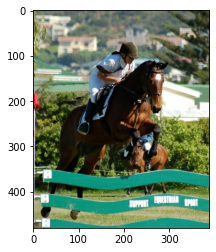

In [14]:
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    # print(ColorLayoutDescripter(image))
    break

In [15]:
effnet = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling="avg",
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)


In [16]:
def add_features_to_dataset(dataset,cachename):
    images = dataset.map(lambda x: x["image"])
    feature_sets = []
    # order is important here, must be same as defined in enabled_names
    if CLD_ENABLED:
        cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x], Tout=np.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld").prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(cld_features)
    if EFFNET_ENABLED:
        resized_images = dataset.map(lambda x: tf.image.resize(x["image"], [240, 240])).batch(1024)
        effnet_features = resized_images.map(lambda x: effnet(x)).unbatch().cache("data/"+cachename+"_effnet").prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(effnet_features)
    # We could do feature scaling here

    # this here insers the values of all featuresets into the dictionary
    complete_dataset = tf.data.Dataset.zip((dataset,) + tuple(feature_sets)).map(
        lambda x, *y: x.update({enabled_names[i]: y[i] for i in range(len(enabled_names))}) or x,
        num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    # I dediced to return dict here. They have the advantage that you can disable/add Features add will without having to condider ordering. Also we do not loose any information, which we might use later
    return complete_dataset


# after first run this should be cached memory (needs full run)
train_complete = add_features_to_dataset(train_data,"train")
val_complete = add_features_to_dataset(val_data, "val")

def get_all_features(datapoint):
    return np.concatenate([datapoint[enabled_names[i]] for i in range(len(enabled_names))])


In [17]:
# forces caching
for i in train_complete:
    pass
for i in val_complete:
    pass

In [18]:
for i in train_complete:
    print(i.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects', 'cld', 'effnet'])



Surf does not work in newer opencv versions, so we have to use an older one or build it ourselves


In [19]:
surf = cv.xfeatures2d.SURF_create()

In [20]:
for data in train_complete:
    x = data['image']
    print(x.shape)
    kp = surf.detect(x.numpy(), None)
    # compute the descriptors with ORB
    kp, des = surf.compute(x.numpy(), kp)
    print(len(kp))
    print(len(des[0]))
    break

(480, 389, 3)
1795
64


In [21]:
train_complete_list = list(train_complete.as_numpy_iterator())

In [22]:
import ipywidgets as widgets
import asyncio
from IPython.display import display
import time
from operator import itemgetter

#this is only an estimate because overlap is not considered
#TODO correcly calculate overlap
def calculate_label_area(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
    
def calculate_label_area_helper(obj_labels,obj_boundingbox,labels):
        areas=[]
        for label in labels:
            area_estimate=0
            foundbbox=[]
            for k,boundinglabel in enumerate(obj_labels):
                if(boundinglabel!=label): continue
                y_min,x_min,y_max,x_max=obj_boundingbox[k]
                #Here we could calulate the overlap to the other boxes
                area_estimate+=(y_max-y_min)*(x_max-x_min)
            areas.append(area_estimate)
        return areas 
    
def get_max_label_helper(obj_labels,obj_boundingbox,labels):
        areas=calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
        max_arg,_=max(enumerate(areas), key=itemgetter(1))
        return labels[max_arg]

def get_max_label(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return get_max_label_helper(obj_labels,obj_boundingbox,labels)



class MaximumQueriesExceeded(Exception):
    pass

class LabelOracle:
    def __init__(self, data, max_queries_cnt=100,max_querry=False,area_difference_weight=1.0,different_labels_weight=2):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.different_labels_weight=different_labels_weight
        self.area_difference_weight=area_difference_weight
        if(max_querry):
            self.query=self.query_max
        else:
            self.query=self.query_heuristic


    def query_heuristic(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            set_a=set(self.data[i]["labels"])
            set_b=set(self.data[j]["labels"])
            sameclasses=set_a.intersection(set_b)
            only_a=set_a-set_b
            only_b=set_b-set_a
            if(len(sameclasses)==0) :return False
            same_area_i=sum(calculate_label_area(self.data[i]["objects"],sameclasses))
            same_area_j=sum(calculate_label_area(self.data[j]["objects"],sameclasses))
            
            diff_area_i=sum(calculate_label_area(self.data[i]["objects"],only_a))
            diff_area_j=sum(calculate_label_area(self.data[j]["objects"],only_b))
            areaquot=same_area_i/same_area_j
            if(areaquot<1):
                areaquot=1.0/areaquot
            score1=1/(1+self.area_difference_weight*areaquot)
            #heuristics 2 depends on share of similiar clases to difference clasesses
            difference_adjusted_i=diff_area_i/same_area_i
            difference_adjusted_j=diff_area_j/same_area_j
            #heuristics are multiplied
            score2=1/(1+self.different_labels_weight*(difference_adjusted_j+difference_adjusted_i))
            score12=score1*score2
            if(score12<0.1):
                if(score12>0.05):
                    #print(set_a)
                    #print(set_b)
                    #print(score1)
                    #print(difference_adjusted_i)
                    #print(difference_adjusted_j)
                    #print(score2)
                    #print(score12)
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
                    pass
                return False
            return True                  
                            
        else:
            raise MaximumQueriesExceeded
    #helps with evaluation because the result depends only on one label so labeled cluster evaultion methods can be used       
    def query_max(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            max_label_i=get_max_label(self.data[i]["objects"],self.data[i]["labels"])
            max_label_j=get_max_label(self.data[j]["objects"],self.data[j]["labels"])
            #if((max_label_i == self.data[j]["labels"][max_arg_j])):
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
            return max_label_i == max_label_j      
        else:
            raise MaximumQueriesExceeded

    

# y for must link, everything else is cannot link
class ExpertOracle:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.run(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            x=input() 
            clear_output(wait=True)
            if x=="y":
                return True
            else:
                
                return False
     
        else:
            raise MaximumQueriesExceeded
#Press Button for answer, needs seperate thread            
from IPython.display import clear_output            
            
class ExpertOracle2:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.buttonAcc=widgets.Button(description="Must Link")
        self.buttonRej=widgets.Button(description="Cannot Link")
        self.buttonAcc.on_click(self.retTrue)
        self.buttonRej.on_click(self.retFalse)
        self.result=-1
        

    def retTrue(a,b):
         a.result=1
    def retFalse(a,b):
         a.result=0    

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.ensure_future(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            display(widgets.HBox([self.buttonAcc,self.buttonRej]))
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            
            while(self.result==-1):
                time.sleep(0.05)
                pass
            clear_output(wait=True)
            if self.result== 1:
                self.result=-1
                return True
            else:
                self.result=-1
                return False
        else:
            raise MaximumQueriesExceeded


In [23]:
y = list(train_complete.map(lambda x: (x['objects']['label'],x['objects']['bbox'],x['labels'])).map(lambda x,y,z:tf.py_function(func=get_max_label_helper, inp=[x,y,z], Tout=np.int64),num_parallel_calls=tf.data.AUTOTUNE).as_numpy_iterator())


In [24]:
x = np.array(list(train_complete.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)




In [25]:
images = list(train_complete.map(lambda x: x['image']).as_numpy_iterator())

In [26]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(x)

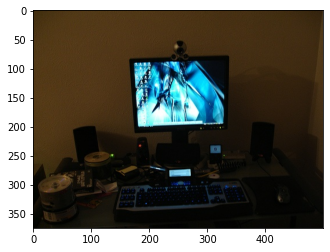

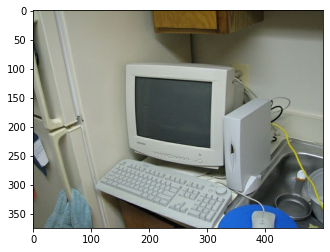

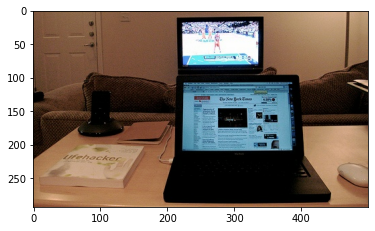

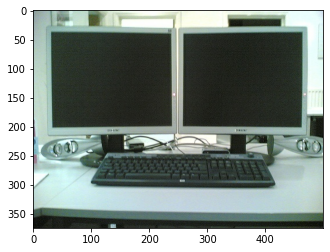

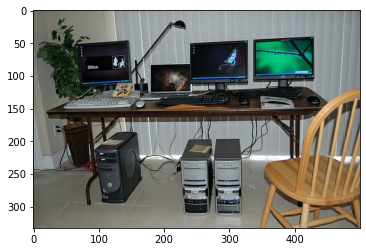

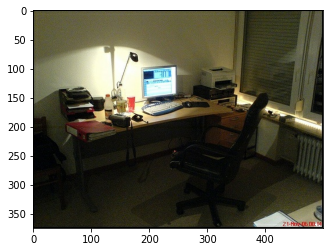

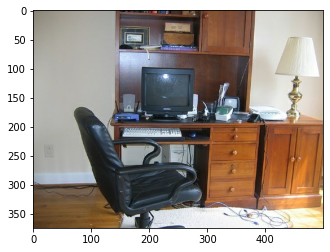

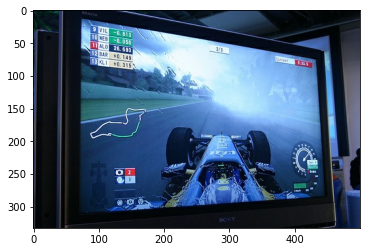

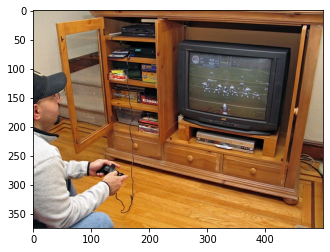

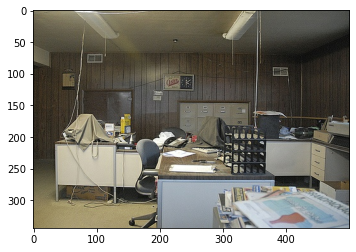

In [27]:
if EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['effnet']
        pred = kmeans.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 3:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [28]:
x2 = np.array(list(train_complete.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
#scaler=RobustScaler()
#x2 = scaler.fit_transform(x2)

In [29]:
kmeans2 = KMeans(n_clusters=20, random_state=0).fit(x2)

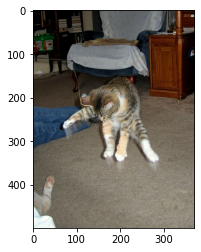

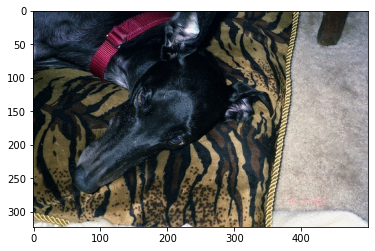

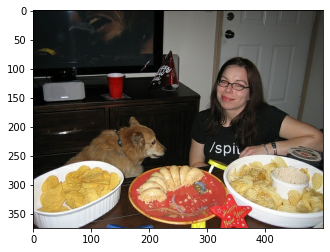

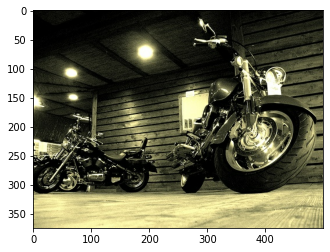

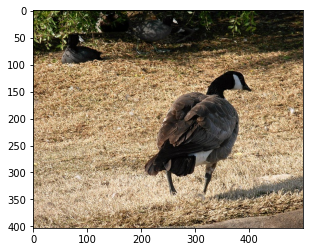

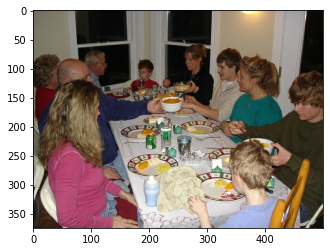

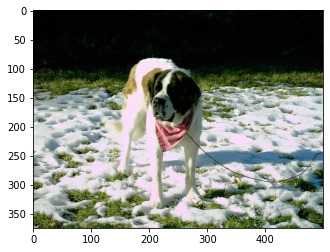

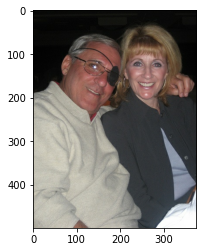

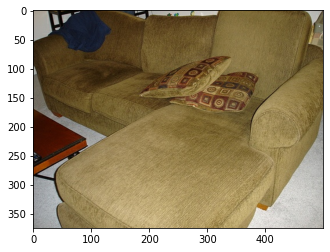

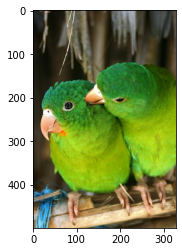

In [30]:
if CLD_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']
        pred = kmeans2.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 2:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [31]:
oracle = LabelOracle(train_complete_list, max_queries_cnt=1000,max_querry=True)
from threading import Thread
active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusers=20)

active_learner.fit(x2, oracle)
#use this for expert Orcacle 2 due to blocking
#thread = Thread(target = active_learner.fit, args = (x2, oracle))
#thread.start()


In [32]:
#use this for expert Orcacle 2 due to blocking
#thread.join(timeout=3)
pairwise_constraints = active_learner.pairwise_constraints_

pairwise_constraints= (loaded_weights[0]+pairwise_constraints[0],\
                       loaded_weights[1]+pairwise_constraints[1])
if LOAD_WEIGHTS:
    with open('data/expert_weights', 'wb') as handle:
         pickle.dump(pairwise_constraints, handle)


In [33]:
clusterer = COPKMeans(n_clusters=20)
clusterer.fit(x2/100, ml=pairwise_constraints[0], cl=pairwise_constraints[1])


In [34]:
metrics.adjusted_rand_score(y, kmeans2.predict(x2))



0.015431469492363967

In [35]:
#These results were not very good
#Lets test this other clustering method

from sklearn.cluster import AgglomerativeClustering,DBSCAN
from scipy.sparse.csgraph import shortest_path
from scipy.spatial import distance
dist=distance.cdist(x2,x2)
for c in pairwise_constraints[0]:
    dist[c[0],c[1]]=0.00001
    dist[c[1],c[0]]=0.00001
dist=shortest_path(dist)
maxdist=dist.max()
for c in pairwise_constraints[1]:
    dist[c[0],c[1]]=maxdist+1
    dist[c[1],c[0]]=maxdist+1


In [36]:
dist

array([[  0.        , 535.82366338, 489.01739136, ..., 538.13288382,
        733.47392464, 552.99187249],
       [535.82366338,   0.        , 569.70783147, ..., 612.34957702,
        658.7389483 , 548.14141621],
       [489.01739136, 569.70783147,   0.        , ..., 550.10817977,
        758.99934684, 504.61867929],
       ...,
       [538.13288382, 612.34957702, 550.10817977, ...,   0.        ,
        806.49426657, 451.65142739],
       [733.47392464, 658.7389483 , 758.99934684, ..., 806.49426657,
          0.        , 795.02453132],
       [552.99187249, 548.14141621, 504.61867929, ..., 451.65142739,
        795.02453132,   0.        ]])

In [37]:
preds = AgglomerativeClustering(n_clusters=20,linkage='average',affinity="precomputed").fit_predict(dist)
metrics.adjusted_rand_score(y, preds)


-8.481234352067938e-07

In [38]:
pred = AgglomerativeClustering(n_clusters=20,linkage='average').fit_predict(x2)
metrics.adjusted_rand_score(y, pred)

-0.008808481993930988

1e-05
True
True
(480, 389, 3)


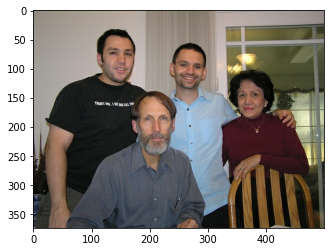

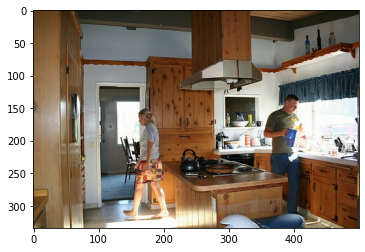

In [39]:

for c in pairwise_constraints[0]:
    print(dist[c[0],c[1]])
    print(y[c[0]]==y[c[1]])
    print(preds[c[0]]==preds[c[1]])
    print(images[0].shape)
    plt.imshow(images[c[0]])
    plt.show()
    plt.imshow(images[c[1]])
    plt.show()
    break
    
    

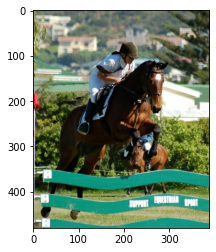

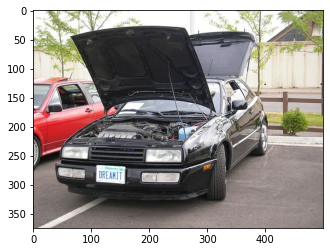

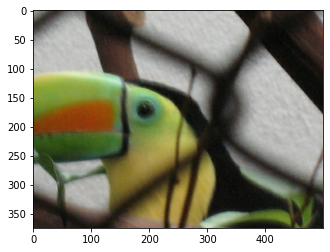

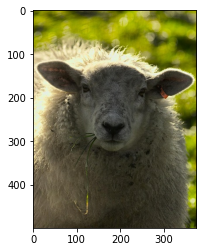

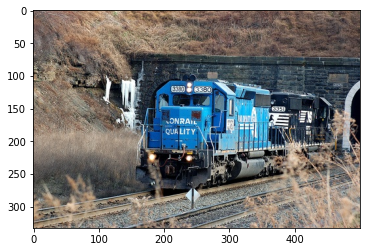

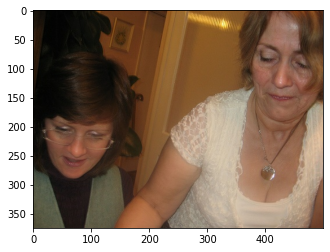

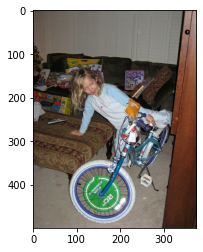

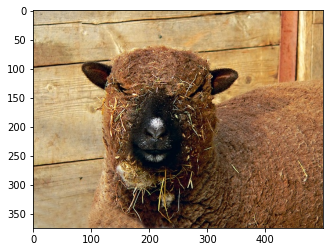

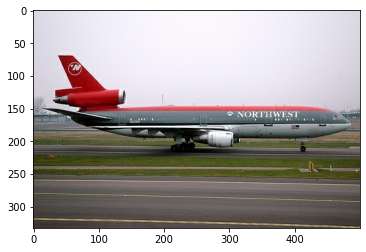

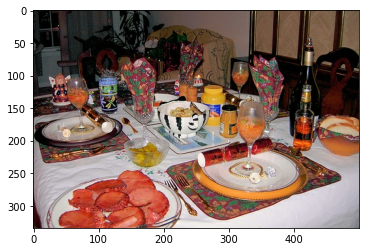

In [40]:
i=0
if CLD_ENABLED:
    counter = 0
    for data in train_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']

        if preds[i] == 0:
            plt.imshow(im)
            plt.show()
            counter += 1
            if counter == 10:
                break
        i+=1

In [41]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_complete.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [42]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_complete.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [43]:

np.var(x3[:, 192:])

0.09804496884346764

In [44]:
kmeans3 = KMeans(n_clusters=20, random_state=0).fit(x3)

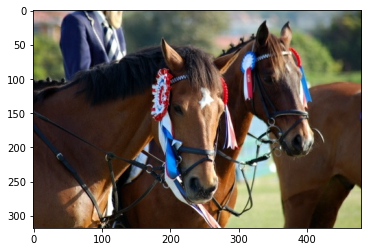

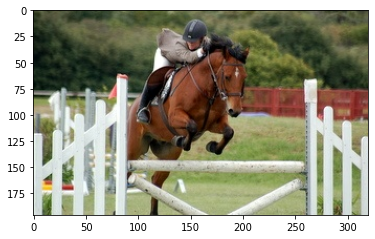

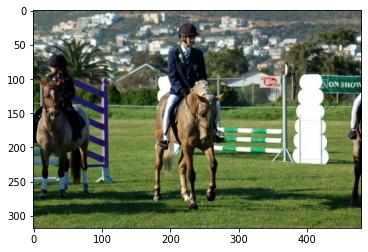

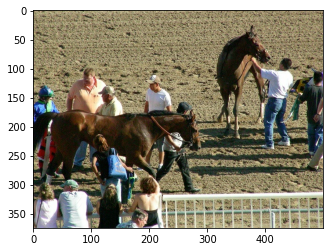

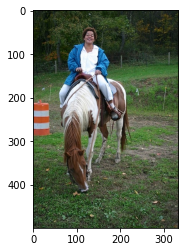

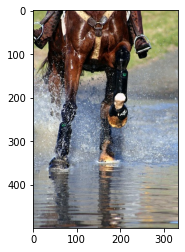

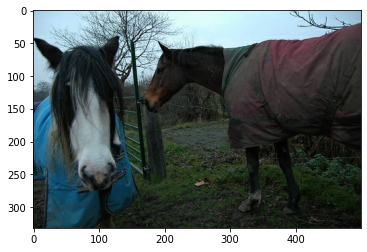

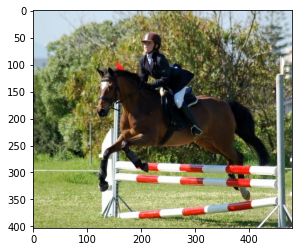

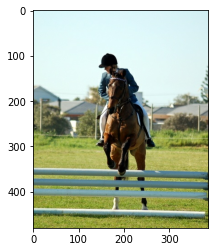

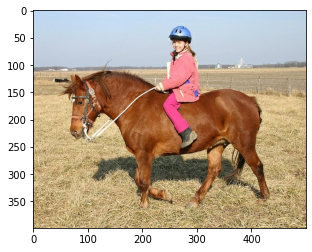

In [45]:
if CLD_ENABLED and EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = tf.concat((data['cld'] * weight_cdf, data['effnet']), axis=0)
        pred = kmeans3.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 3:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break
